In [1]:
%load_ext autoreload
%autoreload 2
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
import matplotlib.pyplot as plt
from model_mlp_logit import GPTNeoXForLogitCorrection, OPTForLogitCorrection, GPT2ForLogitCorrection
from train_logits_prediction_model import compose_dataset

device = 'cuda:0'
device_1 = 'cuda:4'
device_LLM = 'cuda:5'

In [2]:
#model_name_or_path = "/mnt/efs/Haw-Shiuan/true_entropy/models/OWT_wiki_1e7_70M_bsz_128_exp_pred_last_a10_e3"
#model_name_or_path = "/mnt/efs/Haw-Shiuan/AP_sampling/models/prob_OWT_1e6_70M_bsz_128_a10_e3_lr-4"
#model_name_or_path = "/mnt/efs/Haw-Shiuan/AP_sampling/models/prob_wiki_1e6_70M_bsz_64_a10_e3_last_w_20"
#model_name_or_path = "/mnt/efs/Haw-Shiuan/AP_sampling/models/prob_wiki_1e6_70M_bsz_64_a10_e3_top_w_20"
#model_name_or_path = "/mnt/efs/Haw-Shiuan/AP_sampling/models/prob_wiki_1e6_70M_bsz_64_e3_in_small_only_top_last_w_10_l1"
#model_name_or_path = "/mnt/efs/Haw-Shiuan/AP_sampling/models/prob_wiki_1e6_70M_bsz_64_e10_in_small_only_top_last_w_10_l1"
#model_name_or_path = "/mnt/efs/Haw-Shiuan/AP_sampling/models/prob_wiki_1e6_70M_bsz_64_e3_only_top_last_w_10_l1_reg_w_1"
#model_name_or_path = "/mnt/efs/Haw-Shiuan/AP_sampling/models/prob_wiki_1e6_70M_bsz_64_e3_only_top_last_w_10_l1_reg_w_20_lr-4"
#model_name_or_path = "/mnt/efs/Haw-Shiuan/AP_sampling/models/prob_wiki_ext_1e6_70M_bsz_64_e5_only_top_last_w_10_l1_reg_w_5_lr-4"
#model_name_or_path = "/mnt/efs/Haw-Shiuan/AP_sampling/models/prob_wiki_ext_1e6_70M_bsz_64_e5_only_top_last_w_10_l1_reg_w_75_lr-4"
#model_name_or_path = "/mnt/efs/Haw-Shiuan/AP_sampling/models/prob_opt_wiki_ext_1e6_70M_bsz_32_e3_only_top_last_w_10_l1_reg_w_5_lr-4"
#model_name_or_path = "/mnt/efs/Haw-Shiuan/AP_sampling/models/prob_opt_wiki_ext_1e6_70M_bsz_32_e5_only_top_last_w_10_l1_reg_w_10_lr-4"
#model_name_or_path = "/mnt/efs/Haw-Shiuan/AP_sampling/models/prob_wiki_ext_1e6_70M_bsz_64_e5_only_top_last_w_10_l1_reg_w_02_logit_lr-4"
#model_name_or_path = "/mnt/efs/Haw-Shiuan/AP_sampling/models/prob_wiki_ext_1e6_70M_bsz_64_e5_only_top_last_w_10_l1_reg_w_04_logit_lr-4"
#model_name_or_path = "/mnt/efs/Haw-Shiuan/AP_sampling/models/prob_wiki_ext2_1e6_70M_bsz_64_e5_only_top_last_w_10_l1_reg_w_08_logit_a3_lr-4"
model_name_or_path = "/mnt/efs/Haw-Shiuan/AP_sampling/models/prob_wiki_ext2_1e6_70M_bsz_64_e5_only_top_last_w_10_l1_reg_w_08_logit_exp_decay_lr-4"
#model_name_or_path = "/mnt/efs/Haw-Shiuan/AP_sampling/models/prob_wiki_ext2_1e6_70M_bsz_64_e5_only_top_last_w_10_l1_reg_w_08_logit_exp_decay_ld_lr-4"
#model_name_or_path = "/mnt/efs/Haw-Shiuan/AP_sampling/models/bug/prob_opt_wiki_ext_1e6_70M_bsz_32_e5_only_top_last_w_10_l1_reg_w_04_logit_exp_decay_lr-4"
#model_name_or_path = "/mnt/efs/Haw-Shiuan/AP_sampling/models/prob_opt_wiki_ext_new_1e6_70M_bsz_32_e5_only_top_last_w_10_l1_reg_w_06_logit_exp_decay_lr-4"
#model_name_or_path = "/mnt/efs/Haw-Shiuan/AP_sampling/models/prob_opt_wiki_ext_new_1e6_70M_bsz_32_e5_only_top_last_w_10_l1_reg_w_04_logit_exp_decay_lr-4"
#model_name_or_path = "/mnt/efs/Haw-Shiuan/AP_sampling/models/prob_gpt2_wiki_ext_new_1e6_70M_bsz_32_e5_only_top_last_w_10_l1_reg_w_008_logit_exp_decay_lr-4"
#model_name_or_path = "/mnt/efs/Haw-Shiuan/AP_sampling/models/prob_gpt2_wiki_ext_new_1e6_70M_bsz_32_e5_only_top_last_w_10_l1_reg_w_04_logit_exp_decay_lr-4"

def extract_param(raw_name, param_prefix, param_suffix):
    if param_prefix not in raw_name:
        return 3
    prefix_start = raw_name.index(param_prefix)
    start_idx = prefix_start+len(param_prefix)
    if param_suffix is None:
        return int(raw_name[start_idx:])
    end_idx = raw_name[start_idx:].index(param_suffix)
    #print(start_idx, end_idx)
    return int(raw_name[start_idx:start_idx+end_idx])

poly_degree = 3

model_logit_decay = False
if '_ld_' in model_name_or_path:
    model_logit_decay = True

if '_exp_decay_' in model_name_or_path:
    decay_function='exp'
elif '_logistic_decay_' in model_name_or_path:
    decay_function='logistic'
elif 'scaled_a' in model_name_or_path:
    decay_function='scaled_poly'
    poly_degree = extract_param(model_name_or_path, '_a', '_')
else:
    decay_function='poly'
    poly_degree = extract_param(model_name_or_path, '_a', '_')
print(decay_function, poly_degree)

if '_opt_' in model_name_or_path:
    model_class = OPTForLogitCorrection
    log_model_size = [18.2771614, 19.5373201, 20.9161984, 21.6486751, 22.5877428]
elif '_gpt2_' in model_name_or_path:
    model_class = GPT2ForLogitCorrection
    log_model_size = [18.25882042, 19.52696825, 20.37850591, 21.1123045]
else:
    model_class = GPTNeoXForLogitCorrection
    log_model_size = [16.75548316, 18.25882042, 19.52696825, 20.50726726, 20.91273067, 21.64659275, 22.58644061]    

model = model_class.from_pretrained(
    model_name_or_path,
    #log_model_size=log_model_size, use_a4=True, use_a56=True, use_a10=True
    log_model_size=log_model_size, decay_function=decay_function,poly_degree=poly_degree,model_logit_decay=model_logit_decay
)
model = model.to(device)
model.eval()

exp 3
logit_reg_w 0.8


GPTNeoXForLogitCorrection(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXSdpaAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
 

In [3]:
if '_opt_' in model_name_or_path:
    model_name = 'facebook/opt-125m'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
elif '_gpt2_' in model_name_or_path:
    model_name = 'openai-community/gpt2'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
else:
    model_name = 'EleutherAI/pythia-70m-deduped'
    tokenizer = AutoTokenizer.from_pretrained(model_name)

/mnt/efs/conda/envs/latest_hf/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
model_small = AutoModelForCausalLM.from_pretrained(model_name)
model_small = model_small.to(device_1)
model_small.eval()

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXSdpaAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
        

In [5]:
import os
from datasets import load_from_disk
#validation_text_file = '/mnt/efs/Haw-Shiuan/true_entropy/data/processed/openwebtext17-18_1e6_Pythia/tensors_all/val_org.pt'
#validation_label_folder = '/mnt/efs/Haw-Shiuan/true_entropy/data/processed/openwebtext17-18_1e6_Pythia/entropy_tensor/val'
#validation_text_file = '/mnt/efs/Haw-Shiuan/true_entropy/data/processed/openwebtext17-18_1e6_Pythia/tensors_all/val_org.pt'
#validation_label_folder = '/mnt/efs/Haw-Shiuan/AP_sampling/data/processed/openwebtext17-18_1e6_Pythia/prob_tensor_1024/val'

if '_opt_' in model_name_or_path:
    validation_text_file = '/mnt/efs/Haw-Shiuan/true_entropy/data/processed/wiki2021_1e6_OPT/tensors_all/val_org.pt'
    validation_label_folder = '/mnt/efs/Haw-Shiuan/AP_sampling/data/processed/wiki2021_1e6_OPT/prob_opt_tensor_1024_new/val'
    
    model_prefix = 'facebook_opt-'
    ext_data = False
    ext_data_2 = False
    model_names = ["125m", "350m", "1.3b", "2.7b", "6.7b"]
    log_model_size = [18.2771614, 19.5373201, 20.9161984, 21.6486751, 22.5877428]
    w_idx_model_name = model_prefix + model_names[-1] #largest LLM name
    file_suffix = '_0_20,20_100,100_inf_k_20,5,10_bptt_1024.pt'
    cache_file_name = 'cache_logit_ext_new_' + w_idx_model_name + file_suffix.replace('.pt','.hf')
    small_model_name = model_prefix + model_names[0]
    file_prefix = 'prob_' + model_prefix

    cache_eval_file_path = '/mnt/efs/Haw-Shiuan/AP_sampling/data/processed/wiki2021_1e6_OPT/prob_opt_tensor_1024_new/val/' + cache_file_name    

    # validation_text_file = '/mnt/efs/Haw-Shiuan/true_entropy/data/processed/wiki2021_1e4_Pythia/tensors_all/val_org.pt'
    # validation_label_folder = '/mnt/efs/Haw-Shiuan/AP_sampling/data/processed/wiki2021_1e4_Pythia/prob_opt_tensor_1024_new/val'
    
    # model_prefix = 'facebook_opt-'
    # ext_data = False
    # ext_data_2 = False
    # model_names = ["125m", "350m", "1.3b", "2.7b", "6.7b"]
    # log_model_size = [18.2771614, 19.5373201, 20.9161984, 21.6486751, 22.5877428]
    # w_idx_model_name = model_prefix + model_names[-1] #largest LLM name
    # file_suffix = '_0_20,20_100,100_inf_k_20,5,10_bptt_1024.pt'
    # cache_file_name = 'cache_logit_ext_' + w_idx_model_name + file_suffix.replace('.pt','.hf')
    # small_model_name = model_prefix + model_names[0]
    # file_prefix = 'prob_' + model_prefix

    # cache_eval_file_path = '/mnt/efs/Haw-Shiuan/AP_sampling/data/processed/wiki2021_1e6_Pythia/prob_opt_tensor_1024_new/val/' + cache_file_name


    # cache_file_name = 'cache_logit_ext_facebook_opt-6.7b_0_10,10_100,100_inf_k_10,5,5_bptt_1024.hf'
    # cache_file_name = 'cache_logit_ext_new_facebook_opt-6.7b_0_20,20_100,100_inf_k_20,5,10_bptt_1024.hf'
    

    # validation_text_file = '/mnt/efs/Haw-Shiuan/true_entropy/data/processed/wiki2021_1e6_Pythia/tensors_all/val_org.pt'
    # validation_label_folder = '/mnt/efs/Haw-Shiuan/AP_sampling/data/processed/wiki2021_1e6_Pythia/prob_opt_tensor_1024/val'
    
    # #cache_file_name = 'cache_logit_ext_facebook_opt-6.7b_0_10,10_100,100_inf_k_10,5,5_bptt_1024.hf'
    # cache_file_name = 'cache_logit_ext_2_facebook_opt-6.7b_0_20,10_100,100_inf_k_20,5,5_bptt_1024.hf'
    
    # cache_eval_file_path = '/mnt/efs/Haw-Shiuan/AP_sampling/data/processed/wiki2021_1e6_Pythia/prob_opt_tensor_1024/val/' + cache_file_name

elif '_gpt2_' in model_name_or_path:
    validation_text_file = '/mnt/efs/Haw-Shiuan/true_entropy/data/processed/wiki2021_1e6_GPT2/tensors_all/val_org.pt'
    validation_label_folder = '/mnt/efs/Haw-Shiuan/AP_sampling/data/processed/wiki2021_1e6_GPT2/prob_opt_tensor_1024_new/val'
    
    model_prefix = 'openai-community_gpt2'
    ext_data = False
    ext_data_2 = False
    model_names = ["", "-medium", "-large", "-xl"]
    log_model_size = [18.25882042, 19.52696825, 20.37850591, 21.1123045]
    w_idx_model_name = model_prefix + model_names[-1] #largest LLM name
    file_suffix = '_0_20,20_100,100_inf_k_20,5,10_bptt_1024.pt'
    cache_file_name = 'cache_logit_ext_new_' + w_idx_model_name + file_suffix.replace('.pt','.hf')
    small_model_name = model_prefix + model_names[0]
    file_prefix = 'prob_' + model_prefix

    cache_eval_file_path = '/mnt/efs/Haw-Shiuan/AP_sampling/data/processed/wiki2021_1e6_GPT2/prob_opt_tensor_1024_new/val/' + cache_file_name    
else:
    validation_text_file = '/mnt/efs/Haw-Shiuan/true_entropy/data/processed/wiki2021_1e6_Pythia/tensors_all/val_org.pt'
    validation_label_folder = '/mnt/efs/Haw-Shiuan/AP_sampling/data/processed/wiki2021_1e6_Pythia/prob_tensor_1024/val'
    
    #cache_file_name = 'cache_logit_ext_EleutherAI_pythia-6.9b-deduped_10_100,100_inf_k_5,5_bptt_1024.hf'
    cache_file_name = 'cache_logit_ext_2_EleutherAI_pythia-6.9b-deduped_10_20,10_100,100_inf_k_10,5,5_bptt_1024.hf'
    
    cache_eval_file_path = '/mnt/efs/Haw-Shiuan/AP_sampling/data/processed/wiki2021_1e6_Pythia/prob_tensor_1024/val/' + cache_file_name



#print('load cache: ', cache_eval_file_path)
#eval_dataset = load_from_disk(cache_eval_file_path)

#print(os.path.exists(cache_eval_file_path))

if os.path.exists(cache_eval_file_path):
    print('load cache: ', cache_eval_file_path)
    eval_dataset = load_from_disk(cache_eval_file_path)
else:
    eval_dataset = compose_dataset(validation_text_file, validation_label_folder,w_idx_model_name, small_model_name, file_suffix, file_prefix, model_names, ext_data, ext_data_2)
    eval_dataset.save_to_disk(cache_eval_file_path)




load cache:  /mnt/efs/Haw-Shiuan/AP_sampling/data/processed/wiki2021_1e6_Pythia/prob_tensor_1024/val/cache_logit_ext_2_EleutherAI_pythia-6.9b-deduped_10_20,10_100,100_inf_k_10,5,5_bptt_1024.hf


In [7]:
from model_mlp_logit import uncompress_label_tensor

def concat_matirxes(all_prob_curve, lm_top_prob, LLM_CD_prob, i):
    return np.concatenate( (all_prob_curve[:,i,:], np.expand_dims(lm_top_prob[:,i], axis=-1), np.expand_dims(LLM_CD_prob[:,i], axis=-1) ), axis=-1 )

def visualize_results(doc, lm_top_prob, all_prob_curve, top_idx, LLM_CD_prob):
    #doc_tok = [x.replace('Ġ',' ') for x in tokenizer.tokenize(doc)]
    doc_tok = [tokenizer.convert_ids_to_tokens(x).replace('Ġ',' ') for x in doc]
    num_fig = 20
    #num_fig = 5
    #print(len(top_idx))
    top_tok = [tokenizer.convert_ids_to_tokens(top_idx[i]) for i in range(len(top_idx))]
    top_tok_trans = list(zip(*top_tok))
    
    fig, ax_list = plt.subplots(1, num_fig+1, figsize=(20,len(doc_tok)/2), gridspec_kw={'width_ratios': [1]*(num_fig+1) })
    
    ax = ax_list[0]
    all_prob_curve_pred = concat_matirxes(all_prob_curve, lm_top_prob, LLM_CD_prob, 0)
    ax.matshow(all_prob_curve_pred)
    #print(all_prob_curve_pred)
    ax.set_yticks(np.arange(len(doc_tok)), doc_tok)
    for i in range(num_fig):
        pred_tok_list = top_tok_trans[i]
        ax = ax_list[i+1]
        #ax.tick_params(labelleft=True, labelright=True, left=True, right=True)
        all_prob_curve_pred = concat_matirxes(all_prob_curve, lm_top_prob, LLM_CD_prob, i)
        ax.matshow(all_prob_curve_pred)
        #ax.set_ylim(len(doc_tok)/2)
        #ax.set_yticks(np.arange(len(doc_tok)), doc_tok)
        ax.yaxis.tick_right()
        ax.set_yticks(np.arange(len(pred_tok_list)), pred_tok_list)
        #print(len(doc_tok))
        #print(all_prob_curve_pred.shape)
        
        #ax2=ax.twinx()
        #print(ax.get_ylim())
        #ax2.set_ylim(ax.get_ylim())
        #ax2.yaxis.tick_right()
        #ax.yaxis.set_label_position("right")
        #ax2.set_yticks(np.arange(len(pred_tok_list)), pred_tok_list)
        #print(len(pred_tok_list))
        
        
    plt.show()

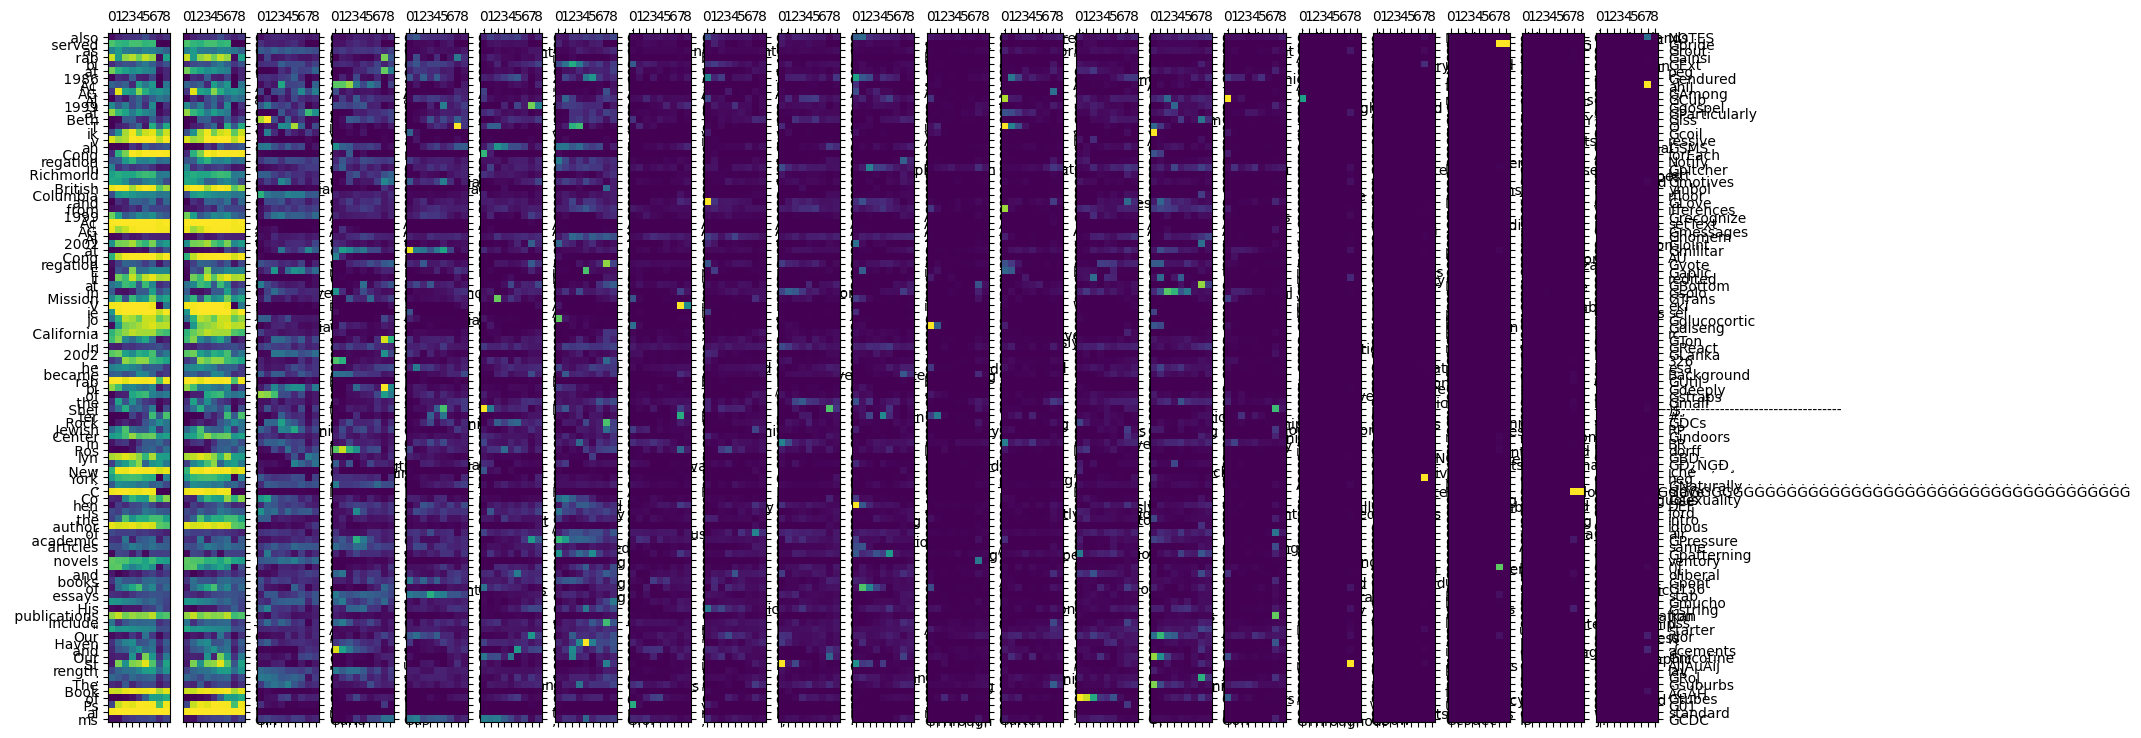

In [8]:
max_len = 100
for idx, batch in enumerate(eval_dataset):
    if idx == 1:
        input_ids = torch.tensor(batch["input_ids"][:max_len]).unsqueeze(0).to(device)
        labels = torch.tensor(batch["labels"][:max_len]).unsqueeze(0)
        all_prob_curves, LLM_top_w, LLM_top_logit, small_logits_tesnor = uncompress_label_tensor(labels)
        all_prob_curves = all_prob_curves / (1e-23 + all_prob_curves.sum(dim=-2, keepdim=True))

        #print(input_ids)
        #print(input_ids.size())
        #print(labels.size())
        #print(LLM_top_w.size())
        with torch.no_grad():
            output = model(input_ids, labels=labels.to(device), return_dict=False)
            output_small = model_small(input_ids.to(device_1), return_dict=True)
        
        lm_top_prob = output[2]
        #lm_logits_top = torch.gather(output[1], dim=-1, index=LLM_top_w.to(device))
        #lm_top_prob =  torch.softmax(LLM_top_logit.to(device) - 0.5 * lm_logits_top, dim=-1)

        LLM_small_logit = torch.gather(output_small.logits, dim=-1, index=LLM_top_w.to(device_1))
        LLM_CD_prob = torch.softmax(LLM_top_logit.to(device_1) - 0.25 * LLM_small_logit, dim=-1)
        
        #text = tokenizer.decode(input_ids[0])
        #visualize_results(text, lm_top_prob.squeeze(0).cpu().numpy(), all_prob_curves.squeeze(0).numpy(), LLM_top_w.squeeze(0))
        visualize_results(input_ids[0].cpu().tolist(), lm_top_prob.squeeze(0).cpu().numpy(), all_prob_curves.squeeze(0).numpy(), LLM_top_w.squeeze(0).tolist(), LLM_CD_prob.squeeze(0).cpu().numpy())
        #print(labels)
        #print(text)
        #plot_entropy_decay(log_model_size, output[1][0,:10,:].cpu().numpy())
        #plot_entropy_decay(log_model_size, output[1][0,:10,:-1].cpu().numpy())
        #plot_entropy_decay(log_model_size, labels[:10,:].numpy())

        break

In [8]:
if '_opt_' in model_name_or_path:
    model_name = 'facebook/opt-6.7b'
elif '_gpt2_' in model_name_or_path:
    model_name = 'openai-community/gpt2-xl'
else:
    model_name = 'EleutherAI/pythia-6.9b-deduped'
model_llm = AutoModelForCausalLM.from_pretrained(model_name)
model_llm.eval()
model_llm.to(device_LLM)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50432, 4096)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=4096, out_features=12288, bias=True)
          (dense): Linear(in_features=4096, out_features=4096, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=4096, out_features=16384, bias=True)
          (dense_4h_to_h): Linear(in_features=16384, out_features=4096, bias=True)

In [6]:
model_name_arr = ['EleutherAI/pythia-70m-deduped', 'EleutherAI/pythia-160m-deduped', 'EleutherAI/pythia-410m-deduped', 'EleutherAI/pythia-1b-deduped', 'EleutherAI/pythia-1.4b-deduped', 'EleutherAI/pythia-2.8b-deduped', 'EleutherAI/pythia-6.9b-deduped']

model_arr = []
#tokenizer = GPT2Tokenizer.from_pretrained(model_name_arr[0])
tokenizer = AutoTokenizer.from_pretrained(model_name_arr[0])
for idx, model_name in enumerate(model_name_arr):
    model_i = AutoModelForCausalLM.from_pretrained(model_name)
    model_i.eval()
    model_i.to('cuda:'+str(idx+1))
    model_arr.append(model_i)

/mnt/efs/conda/envs/latest_hf/lib/python3.8/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
#doc = " Boris Karloff received stars on the Hollywood Walk of Fame. \n\nPersonal life\nKarloff was married to the actress Evelyn Ankers from 1935 to 1938.\n\nDeath\nKarloff died in his"
#doc = " Annie Parisse starred on an American soap opera. She also appeared in a number of movies, including _The Godfather_ and _The Godfather Part II_.\n\n# **DANNY DEVITO**\n\n**FILM,"
#doc = " Sean Combs was raised in Mount Vernon, New York.\n\nCareer\nIn 1982, Combs joined the New York City-based rap group M.O.P. (Masters of the Peculiar). Combs was a member of the"
#doc = " Margaret Osborne duPont was born in March. He is the son of John duPont and Mary Elizabeth. He was a descendent of the duPont family, who were prominent in the American Industrial"
#doc = " Robert Redford directed A River Runs Through It. It was nominated for three Academy Awards, including Best Picture.\n\nIn the 1980s, Redford starred in the film Ordinary People,"
#doc = " GoldenEye is the seventeenth film in the James Bond series. The film was released on November 16, 1995, in the United Kingdom and November 19, 1995, in the United States. The film"
#doc = " Michael Jackson refused to be a musician.\n\nJackson's parents were strict and he was not allowed to listen to music, dance or watch television. He was forbidden to wear shorts,"
#doc = " Dan Martin rides for a professional racing team. He is the only one who has a chance at the championship.\n\nThe race begins in the desert and then heads to the mountains. The"
#doc = " Saw VI is a North American film. It is a sequel to the 2006 film, The Fast and the Furious: Tokyo Drift. It was released in theaters on April 26, 2009. The film was directed by"
#doc = " Cat on a Hot Tin Roof features several recurring motifs, such as superficiality and sexual desire. The play is set in the Deep South of the United States in the 1950s, and the"
#doc = " Walt Disney has a brother name Roy.\nThe name Roy is a variant of the name Robert.\n\nRoy is a variant of the name Robert.\n\nRoy is a variant of the name Robert.\n\nRoy is a"
#doc = " The Twilight Saga includes the American romantic fantasy film \"Twilight\". The film is a story of a young man who falls in love with a vampire girl. The film has been praised by"    

doc = "President of the United States Joe Biden was born in Scranton."
#doc = "President of the United States, Joe Biden was born in Scranton."
#doc = "Barack Obama was born in Honolulu, Hawaii."
#doc = "The capital city of Japan is Tokyo."
#doc = "The capital city of China is Beijing."
#doc = "The capital city of Australia is Canberra."
#doc = "Hillary Clinton is married to Bill Clinton."
#doc = "Bill Clinton is married to Hillary Clinton."
#doc = "Obama was born in Honolulu, Hawaii. After graduating from Columbia University in 1983, he worked as a community organizer in Chicago. In 1988, he enrolled in Harvard Law School, where he was the first black president of the Harvard Law Review. After graduating, he became a civil rights attorney and an academic, teaching constitutional law at the University of Chicago Law School from 1992 to 2004. Turning to elective politics, he represented the 13th district in the Illinois Senate from 1997 until 2004, when he successfully ran for the U.S. Senate. In 2008, after a close primary campaign against Hillary Clinton, he was nominated by the Democratic Party for president and chose Joe Biden as his running mate. Obama was elected over Republican nominee John McCain in the presidential election and was inaugurated on January 20, 2009. Nine months later, he was named the 2009 Nobel Peace Prize laureate, a decision that drew a mixture of praise and criticism."
#doc = doc.lower()
#doc = "Fulton County’s sweeping indictment against former President Donald Trump and 18 additional co-defendants also includes details involving 30 “unindicted co-conspirators” – people who Fulton County District Attorney Fani Willis alleges took part in the criminal conspiracy to overturn the 2020 election. Some of the co-conspirators are key Trump advisers, like Boris Epshteyn, while several others are likely Georgia officials who were the state’s fake electors for Donald Trump. One of the unindicted co-conspirators who appears multiple times in the indictment is Georgia’s Republican Lt. Gov. Burt Jones. Willis was barred by a state judge from investigating Jones after she hosted a fundraiser last year for Jones’ Democratic opponent when he was a state senator running for lieutenant governor."
#doc = """At the end of his term, Trump went to live at his Mar-a-Lago club. As provided for by the Former Presidents Act, he established an office there to handle his post-presidential activities. Trump's false claims concerning the 2020 election were commonly referred to as the "big lie" in the press and by his critics. In May 2021, Trump and his supporters attempted to co-opt the term, using it to refer to the election itself. The Republican Party used Trump's false election narrative to justify the imposition of new voting restrictions in its favor. As late as July 2022, Trump was still pressuring state legislators to overturn the 2020 election by rescinding the state's electoral votes for Biden. Trump resumed his campaign-style rallies with an 85-minute speech at the annual North Carolina Republican Party convention on June 6, 2021. On June 26, he held his first public rally since the January 6 rally that preceded the riot at the Capitol."""
#doc = """A scuba diver named Leroy was exploring an underwater reef. Leroy was gathering coral from the reefs. Under one of the coral plants, Leroy found a wrinkly treasure map. The map indicated there was treasure near the reefs. Leroy searched the reefs looking for the treasure chest. Suddenly, Leroy saw a tan colored treasure chest, but he could not open it. Leroy left the chest behind and swam away. He didn't need the treasure and was happy to simply swim under the sea. """
doc = " " + doc if doc[0] != ' ' else doc
input_ids = torch.tensor(tokenizer.encode(doc)).unsqueeze(0)  # Batch size 1


In [8]:
def visualize_prob(doc, LLM_all_prob, top_idx):
    #doc_tok = [x.replace('Ġ',' ') for x in tokenizer.tokenize(doc)]
    doc_tok = [tokenizer.convert_ids_to_tokens(x).replace('Ġ',' ') for x in doc]
    num_fig = 5
    #print(len(top_idx))
    top_tok = [tokenizer.convert_ids_to_tokens(top_idx[i]) for i in range(len(top_idx))]
    top_tok_trans = list(zip(*top_tok))
    
    fig, ax_list = plt.subplots(1, num_fig+1, figsize=(20,len(doc_tok)/2), gridspec_kw={'width_ratios': [1]*(num_fig+1) })
    
    ax = ax_list[0]
    ax.matshow(LLM_all_prob[:,0,:])
    ax.set_yticks(np.arange(len(doc_tok)), doc_tok)
    for i in range(num_fig):
        pred_tok_list = top_tok_trans[i]
        ax = ax_list[i+1]
        #ax.tick_params(labelleft=True, labelright=True, left=True, right=True)
        ax.matshow(LLM_all_prob[:,i,:])
        #ax.set_ylim(len(doc_tok)/2)
        #ax.set_yticks(np.arange(len(doc_tok)), doc_tok)
        ax.yaxis.tick_right()
        ax.set_yticks(np.arange(len(pred_tok_list)), pred_tok_list)
        #print(len(doc_tok))
        #print(all_prob_curve_pred.shape)
        
        #ax2=ax.twinx()
        #print(ax.get_ylim())
        #ax2.set_ylim(ax.get_ylim())
        #ax2.yaxis.tick_right()
        #ax.yaxis.set_label_position("right")
        #ax2.set_yticks(np.arange(len(pred_tok_list)), pred_tok_list)
        #print(len(pred_tok_list))
        
        
    plt.show()

In [9]:
def visualize_prob_curves(doc, LLM_all_prob, top_idx):
    #doc_tok = [x.replace('Ġ',' ') for x in tokenizer.tokenize(doc)]
    doc_tok = [tokenizer.convert_ids_to_tokens(x).replace('Ġ',' ') for x in doc]
    
    num_start = 0
    #print(len(top_idx))
    top_tok = [tokenizer.convert_ids_to_tokens(top_idx[i]) for i in range(len(top_idx))]
    top_tok_trans = list(zip(*top_tok))

    num_fig = len(doc_tok)- num_start
    #fig, ax_list = plt.subplots(1, num_fig+1, figsize=(20,len(doc_tok)/2), gridspec_kw={'width_ratios': [1]*(num_fig+1) })
    fig, ax_list = plt.subplots(num_fig+1, 2, figsize=(10,40) )
    fig.tight_layout()
    
    print(doc_tok)
    for count in range(num_fig):
        i = count + num_start
        pred_tok_list = top_tok_trans[i]
        print(pred_tok_list)
        ax = ax_list[count][0]
        ax.plot(log_model_size,LLM_all_prob[i,0,:-4])
        ax.set_ylim([0,1])
        
        
        
        #ax.axhline(y = LLM_all_prob[i,0,-3].item(), color = 'blue', linestyle = '-', label='CD T=4')
        ax.axhline(y = LLM_all_prob[i,0,-2].item(), color = 'green', linestyle = '-', label='CD T=2')
        ax.axhline(y = LLM_all_prob[i,0,-1].item(), color = 'red', linestyle = '-', label='CD T=1')
        ax.axhline(y = LLM_all_prob[i,0,-4].item(), color = 'orange', linestyle = '-', label='Asymptotic Probability')
        ax.set_xlabel("Log(Model Size)")
        ax.set_ylabel("Probability")
        ax.legend()
        #ax.set_title('w='+top_tok_trans[0][i] + ' c='+str(doc_tok[:i+1]))
        
        
    plt.show()

[' President', ' of', ' the', ' United', ' States', ' Joe', ' Biden', ' was', ' born', ' in', ' Sc', 'rant', 'on', '.']
('Ġof', 'Ġthe', 'ĠUnited', 'ĠStates', ',', 'ĠBiden', ',', 'Ġin', 'Ġin', 'ĠSc', 'rant', 'on', ',', 'Ċ')
('ĠTrump', 'ĠIndia', 'ĠNational', 'ĠNations', '.', 'ĠB', '.', 'Ġthe', 'Ġon', 'Ġthe', 'o', 'ons', 'ĠPennsylvania', 'ĠHe')
('ĠDonald', 'ĠSouth', 'ĠRepublic', 'ĠKingdom', 'Ġof', 'Ċ', 'Ġand', 'Ġa', '.', 'Ġthis', 'rub', 'ock', '.', 'ĠThe')
('ĠObama', 'ĠChina', 'ĠUniversity', 'Ċ', 'Ġand', 'ĠWilson', 'Ġis', 'Ġon', 'Ġand', 'ĠDelaware', 'it', 'onian', 'Ġin', 'ĠHis')
('ĠBush', 'Ċ', 'ĠAmerican', 'ĠMine', '."', 'ĠAr', 'Ġ(', 'Ġasked', ',', 'Ġ1942', 'ars', 'ony', 'Ġand', 'ĠBiden')
(',', 'ĠIran', 'ĠWorld', 'ĠArab', 'Ċ', 'ĠKennedy', 'Ġhas', 'Ġelected', 'Ġtoday', 'ĠWil', 'her', 'o', 'Ġon', 'ĠIn')
('ĠBarack', 'ĠThe', 'ĠBoard', 'ĠMethodist', 'Ġin', 'ĠMcCarthy', 'Ġsaid', 'Ġalso', 'Ġat', 'Ġ1947', 'ob', 'onia', 'ĠPA', 'ĠJoe')
('Ġand', 'ĠC', 'ĠPhilippines', 'ĠSteel', 'Ġis', 'ĠMan', 'Ċ', 'Ġ

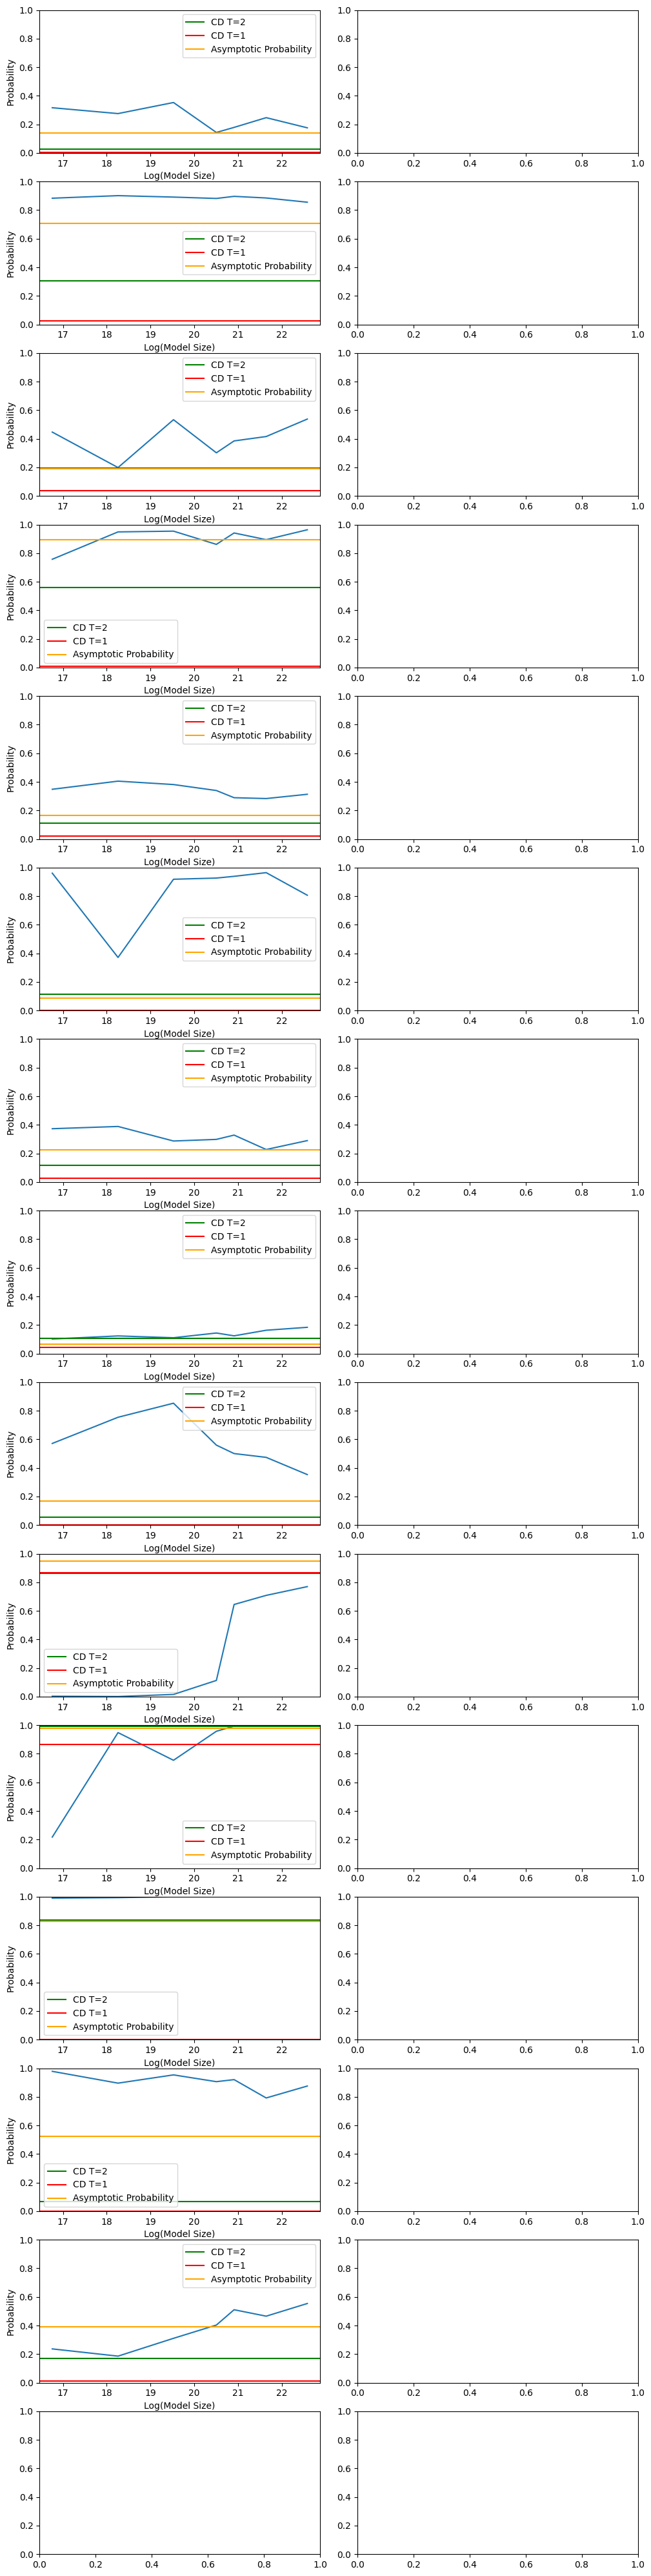

In [10]:
max_len = 100

with torch.no_grad():
    output = model(input_ids.to(device), return_dict=True)

logits_AP = output.logits.to(device).squeeze(0)

logit_arr = []

for model_i in model_arr:
    with torch.no_grad():
        output_i = model_i(input_ids.to(model_i.device), return_dict=True)
        
        #entropy_tensor, top_tok, top_val = word_per((model, tokenizer), doc, True)
        logit_arr.append(output_i.logits.to(device).squeeze(0))

logits_llm = logit_arr[-1]
LLM_top_logit, LLM_top_w = torch.topk(logits_llm, k=20, dim=-1)


AP_top_logit = torch.gather(logits_AP, dim=-1, index=LLM_top_w)

top_logit_arr = []
top_prob_arr = []
for logit_i in logit_arr:
    LLM_top_logit = torch.gather(logit_i, dim=-1, index=LLM_top_w)
    LLM_top_prob = torch.softmax(LLM_top_logit, dim=-1).unsqueeze(-1)
    top_logit_arr.append(LLM_top_logit)
    top_prob_arr.append(LLM_top_prob)

LLM_small_top_logit = top_logit_arr[0]

LLM_AP_prob = torch.softmax(LLM_top_logit - AP_top_logit, dim=-1).unsqueeze(-1)

LLM_CD_prob_T4 = torch.softmax(LLM_top_logit - 0.25 * LLM_small_top_logit, dim=-1).unsqueeze(-1)
LLM_CD_prob_T2 = torch.softmax(LLM_top_logit - 0.5 *  LLM_small_top_logit, dim=-1).unsqueeze(-1)
LLM_CD_prob_T1 = torch.softmax(LLM_top_logit - LLM_small_top_logit, dim=-1).unsqueeze(-1)

top_prob_arr = top_prob_arr + [LLM_AP_prob, LLM_CD_prob_T4, LLM_CD_prob_T2, LLM_CD_prob_T1]

LLM_all_prob = torch.cat( top_prob_arr, dim=-1 )

visualize_prob_curves(input_ids[0].cpu().tolist(), LLM_all_prob.squeeze(0).cpu().numpy(), LLM_top_w.squeeze(0).tolist())




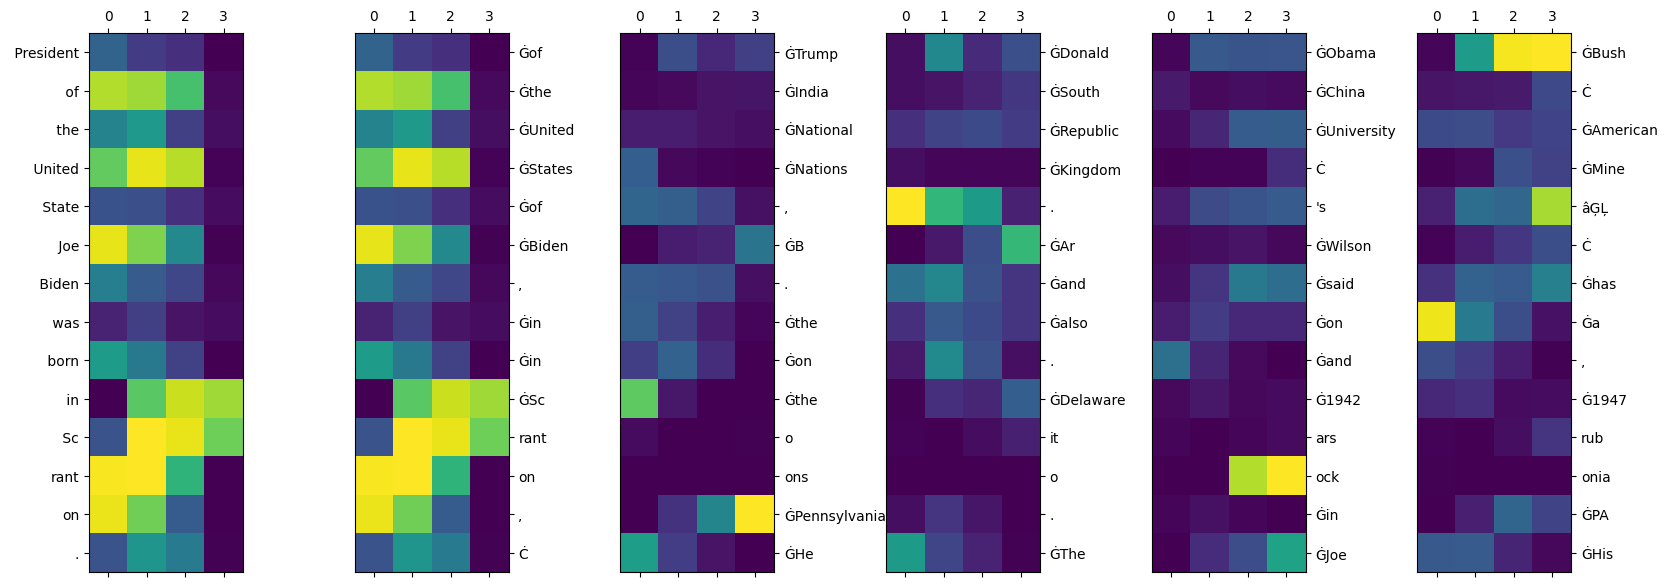

In [123]:
max_len = 100

#print(input_ids)
#print(input_ids.size())
#print(labels.size())
#print(LLM_top_w.size())
with torch.no_grad():
    output = model(input_ids.to(device), return_dict=True)
    output_small = model_small(input_ids.to(device_1), return_dict=True)
    output_llm = model_llm(input_ids.to(device_LLM), return_dict=True)

logits_llm = output_llm.logits.to(device_1).squeeze(0)
logits_AP = output.logits.to(device_1).squeeze(0)
logits_small = output_small.logits.to(device_1).squeeze(0)

LLM_top_logit, LLM_top_w = torch.topk(logits_llm, k=20, dim=-1)

LLM_small_top_logit = torch.gather(logits_small, dim=-1, index=LLM_top_w)
AP_top_logit = torch.gather(logits_AP, dim=-1, index=LLM_top_w)

LLM_small_prob = torch.softmax(LLM_small_top_logit, dim=-1).unsqueeze(-1)
LLM_large_prob = torch.softmax(LLM_top_logit, dim=-1).unsqueeze(-1)
LLM_AP_prob = torch.softmax(LLM_top_logit - AP_top_logit, dim=-1).unsqueeze(-1)
#LLM_CD_prob = torch.softmax(LLM_top_logit - 0.25 * LLM_small_top_logit, dim=-1).unsqueeze(-1)
#LLM_CD_prob = torch.softmax(LLM_top_logit - 0.5 *  LLM_small_top_logit, dim=-1).unsqueeze(-1)
LLM_CD_prob = torch.softmax(LLM_top_logit - LLM_small_top_logit, dim=-1).unsqueeze(-1)

LLM_all_prob = torch.cat( (LLM_small_prob, LLM_large_prob, LLM_AP_prob, LLM_CD_prob), dim=-1 )


visualize_prob(input_ids[0].cpu().tolist(), LLM_all_prob.squeeze(0).cpu().numpy(), LLM_top_w.squeeze(0).tolist())



#text = tokenizer.decode(input_ids[0])
#visualize_results(text, lm_top_prob.squeeze(0).cpu().numpy(), all_prob_curves.squeeze(0).numpy(), LLM_top_w.squeeze(0))
#visualize_results(input_ids[0].cpu().tolist(), lm_top_prob.squeeze(0).cpu().numpy(), all_prob_curves.squeeze(0).numpy(), LLM_top_w.squeeze(0).tolist(), LLM_CD_prob.squeeze(0).cpu().numpy())
#print(labels)
#print(text)
#plot_entropy_decay(log_model_size, output[1][0,:10,:].cpu().numpy())
#plot_entropy_decay(log_model_size, output[1][0,:10,:-1].cpu().numpy())
#plot_entropy_decay(log_model_size, labels[:10,:].numpy())



In [20]:
from transformers import AutoTokenizer, AutoModelForCausalLM
#model_name = 'facebook/opt-6.7b' 
model_name = 'facebook/opt-125m' 
model = AutoModelForCausalLM.from_pretrained(model_name)

In [3]:
print( model.num_parameters() - model.lm_head.weight.numel() )

86630400


In [9]:
print(dict(model.named_parameters()).keys())

dict_keys(['model.decoder.embed_tokens.weight', 'model.decoder.embed_positions.weight', 'model.decoder.final_layer_norm.weight', 'model.decoder.final_layer_norm.bias', 'model.decoder.layers.0.self_attn.k_proj.weight', 'model.decoder.layers.0.self_attn.k_proj.bias', 'model.decoder.layers.0.self_attn.v_proj.weight', 'model.decoder.layers.0.self_attn.v_proj.bias', 'model.decoder.layers.0.self_attn.q_proj.weight', 'model.decoder.layers.0.self_attn.q_proj.bias', 'model.decoder.layers.0.self_attn.out_proj.weight', 'model.decoder.layers.0.self_attn.out_proj.bias', 'model.decoder.layers.0.self_attn_layer_norm.weight', 'model.decoder.layers.0.self_attn_layer_norm.bias', 'model.decoder.layers.0.fc1.weight', 'model.decoder.layers.0.fc1.bias', 'model.decoder.layers.0.fc2.weight', 'model.decoder.layers.0.fc2.bias', 'model.decoder.layers.0.final_layer_norm.weight', 'model.decoder.layers.0.final_layer_norm.bias', 'model.decoder.layers.1.self_attn.k_proj.weight', 'model.decoder.layers.1.self_attn.k_pr

In [4]:
model.lm_head.data,weights[0,:]

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 768, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 768)
      (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-11): 12 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), ep

In [7]:
model.lm_head.weight[0,:]

tensor([ 0.1150, -0.1438,  0.0555,  0.0312,  0.0637,  0.0660,  0.0776,  0.0946,
         0.0717,  0.0584,  0.0729,  0.0752,  0.1063,  0.0601,  0.0458,  0.0683,
         0.0602,  0.0787,  0.0660,  0.1394, -0.1187,  0.0897,  0.0217,  0.0696,
         0.0837,  0.0908,  0.0829,  0.0729,  0.1197,  0.0579,  0.0701,  0.0989,
         0.1283,  0.0430,  0.0767,  0.1032,  0.0714,  0.0586,  0.0883,  0.0698,
         0.0625,  0.0415,  0.0873,  0.0764,  0.0869,  0.0888,  0.0642,  0.0803,
         0.0644,  0.0688,  0.0290,  0.0628,  0.1102,  0.0886,  0.1025,  0.0710,
         0.1078,  0.0579,  0.0969,  0.1368,  0.0584, -0.2263,  0.0327,  0.0898,
         0.0870,  0.0649, -0.0312,  0.1056,  0.0666,  0.0476,  0.0862,  0.0515,
         0.0805,  0.1117,  0.0841,  0.1233,  0.0221,  0.0651,  0.0988,  0.0664,
         0.0738,  0.0906,  0.0690,  0.0628,  0.0448,  0.0780,  0.0639,  0.0711,
         0.0439,  0.0837,  0.2213,  0.0720,  0.1373,  0.0612,  0.0312,  0.0598,
         0.0694,  0.0799,  0.0734,  0.10

In [10]:
model.model.decoder.embed_tokens.weight[0,:]

tensor([ 0.1150, -0.1438,  0.0555,  0.0312,  0.0637,  0.0660,  0.0776,  0.0946,
         0.0717,  0.0584,  0.0729,  0.0752,  0.1063,  0.0601,  0.0458,  0.0683,
         0.0602,  0.0787,  0.0660,  0.1394, -0.1187,  0.0897,  0.0217,  0.0696,
         0.0837,  0.0908,  0.0829,  0.0729,  0.1197,  0.0579,  0.0701,  0.0989,
         0.1283,  0.0430,  0.0767,  0.1032,  0.0714,  0.0586,  0.0883,  0.0698,
         0.0625,  0.0415,  0.0873,  0.0764,  0.0869,  0.0888,  0.0642,  0.0803,
         0.0644,  0.0688,  0.0290,  0.0628,  0.1102,  0.0886,  0.1025,  0.0710,
         0.1078,  0.0579,  0.0969,  0.1368,  0.0584, -0.2263,  0.0327,  0.0898,
         0.0870,  0.0649, -0.0312,  0.1056,  0.0666,  0.0476,  0.0862,  0.0515,
         0.0805,  0.1117,  0.0841,  0.1233,  0.0221,  0.0651,  0.0988,  0.0664,
         0.0738,  0.0906,  0.0690,  0.0628,  0.0448,  0.0780,  0.0639,  0.0711,
         0.0439,  0.0837,  0.2213,  0.0720,  0.1373,  0.0612,  0.0312,  0.0598,
         0.0694,  0.0799,  0.0734,  0.10

In [8]:
def word_per(model_tokenizer, text, cuda):
    top_k_val = 5
    model = model_tokenizer[0]
    tokenizer = model_tokenizer[1]
    assert model is not None
    assert tokenizer is not None
    input_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)  # Batch size 1
    input_ids = input_ids.to(model.device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
    loss, logits = outputs[:2]
    #probs = logits.softmax(dim=-1)
    labels = input_ids
    # we are doing next-token prediction; shift prediction scores and input ids by one
    shift_logits = logits[:, :-1, :].contiguous()
    shift_labels = labels[:, 1:].contiguous()
    loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
    bsz, seq_len_minus_one = shift_labels.size()
    lm_per = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1)).view(bsz, seq_len_minus_one)    
    lm_per = torch.cat( (lm_per, torch.zeros( (bsz,1), device = model.device ) ), dim=1  )
    #ent = - (probs * (1e-23+probs).log() ).sum(dim=-1)
    top_val, top_idx= torch.topk(logits.squeeze(), k=top_k_val, dim=-1)
    top_idx = top_idx.tolist()
    #print(top_idx)
    top_tok = [tokenizer.convert_ids_to_tokens(top_idx[i]) for i in range(len(top_idx))]
    return lm_per.cpu(), top_tok, top_val.cpu()

In [12]:
def visualize_results_old(doc, uncertainty_score1, uncertainty_score2, uncertainty_score3, entropy_matrix_pred, entropy_matrix_labels, top_str=None):
    doc_tok = [x.replace('Ġ',' ') for x in tokenizer.tokenize(doc)]
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(len(doc_tok)/10,50), gridspec_kw={'width_ratios': [3, 1, 1, 7, 7]})
    #plt.figure().set_figwidth(10)
    ax1.matshow(uncertainty_score1)
    ax1.set_yticks(np.arange(len(doc_tok)), doc_tok) 
    ax2.matshow(uncertainty_score2)
    ax3.matshow(uncertainty_score3)
    ax4.matshow(entropy_matrix_pred)
    ax4.set_yticks(np.arange(len(doc_tok)), doc_tok) 
    #plt.yticks(np.arange(len(doc_tok)), doc_tok, rotation='vertical') 
    ax5.yaxis.tick_right()
    ax5.matshow(entropy_matrix_labels)
    ax5.yaxis.set_label_position("right")
    if top_str is not None:
        ax5.set_yticks(np.arange(len(doc_tok)), top_str)
    #ax3.set_yticks(np.arange(len(doc_tok)), top_str_arr[-1]) 

    plt.show()
    

In [9]:
def vis_pred_topk(top_tok, top_val):
    output_list = []
    for i in range(len(top_tok)):
        output_str = ''
        for j in range(len(top_tok[i])):
            output_str += '{}th {}: {:.2f}, '.format(j, top_tok[i][j].replace('Ġ',' '), top_val[i,j].item())
        output_list.append(output_str)
    return output_list

In [6]:
def plot_entropy_decay(log_model_size, entropy_matrix):
    num_w = entropy_matrix.shape[0]
    log_model_size_expand = np.tile(log_model_size, (num_w,1) )
    plt.plot(log_model_size_expand.T,entropy_matrix.T, alpha=0.3)
    plt.xlabel('log(model size)')
    #plt.ylabel('entropy (avg on consecutive 5 words)')
    plt.ylabel('entropy')
    plt.show()

In [7]:
def word_ent(model_tokenizer, text, cuda):
    top_k_val = 5
    model = model_tokenizer[0]
    tokenizer = model_tokenizer[1]
    assert model is not None
    assert tokenizer is not None
    input_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)  # Batch size 1
    input_ids = input_ids.to(model.device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
    loss, logits = outputs[:2]
    probs = logits.softmax(dim=-1)
    #print(probs)
    ent = - (probs * (1e-23+probs).log() ).sum(dim=-1)
    top_val, top_idx= torch.topk(probs.squeeze(), k=top_k_val, dim=-1)
    top_idx = top_idx.tolist()
    #print(top_idx)
    top_tok = [tokenizer.convert_ids_to_tokens(top_idx[i]) for i in range(len(top_idx))]
    return ent.cpu(), top_tok, top_val.cpu()

In [5]:
model_name = 'EleutherAI/pythia-70m-deduped'
model_lm_small = AutoModelForCausalLM.from_pretrained(model_name)
model_lm_small.eval()
model_lm_small.to('cuda:2')

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (a

In [15]:
#entropy_tensor_small, top_tok_small, top_val_small = word_ent((model_lm_small, tokenizer), doc, True)
entropy_tensor_small, top_tok_small, top_val_small = word_per((model_lm_small, tokenizer), doc, True)
#entropy_tensor, top_tok, top_val = word_ent((model_lm, tokenizer), doc, True)
entropy_tensor, top_tok, top_val = word_per((model_lm, tokenizer), doc, True)
top_str = vis_pred_topk(top_tok, top_val)


In [110]:
def visualize_simple_results(doc, uncertainty_score1):
    
    doc_tok = [x.replace('Ġ',' ').replace('Ċ','<newline>') for x in tokenizer.tokenize(doc)]
    print(doc_tok)
    fig, (ax1) = plt.subplots(1,1, figsize=(3,len(doc_tok)/4))
    #plt.figure().set_figwidth(10)
    cax = ax1.matshow(uncertainty_score1)
    #fig.colorbar(cax)
    ax1.set_yticks(np.arange(len(doc_tok)), doc_tok)

    #ax3.set_yticks(np.arange(len(doc_tok)), top_str_arr[-1]) 
    plt.savefig('temp12.png')
    plt.show()

[' The', ' Tw', 'ilight', ' S', 'aga', ' includes', ' the', ' American', ' romantic', ' fantasy', ' film', ' "', 'Tw', 'ilight', '".', ' The', ' film', ' is', ' a', ' story', ' of', ' a', ' young', ' man', ' who', ' falls', ' in', ' love', ' with', ' a', ' vampire', ' girl', '.', ' The', ' film', ' has', ' been', ' praised', ' by']


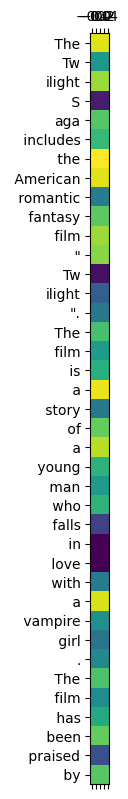

In [111]:
input_ids = torch.tensor(tokenizer.encode(doc)).unsqueeze(0)  # Batch size 1
input_ids = input_ids.to(model.device)

with torch.no_grad():
    #output = model(input_ids,return_dict=False)
    output = model(input_ids,return_dict=False, create_very_large_size=True)
#uncertainty_score1 = (output[1][:,:,-2] - output[2][:,:,0,0]).view(-1,1).cpu()
#uncertainty_score2 = (output[1][:,:,-1] - output[2][:,:,0,0]).view(-1,1).cpu()
uncertainty_score1 = (output[1][:,:,-3] - output[2][:,:,0,0]).view(-1,1).cpu()
#uncertainty_score2 = (output[1][:,:,-1] - output[2][:,:,0,0]).view(-1,1).cpu()
text = tokenizer.decode(input_ids[0])
visualize_simple_results(text, uncertainty_score1.numpy())

 

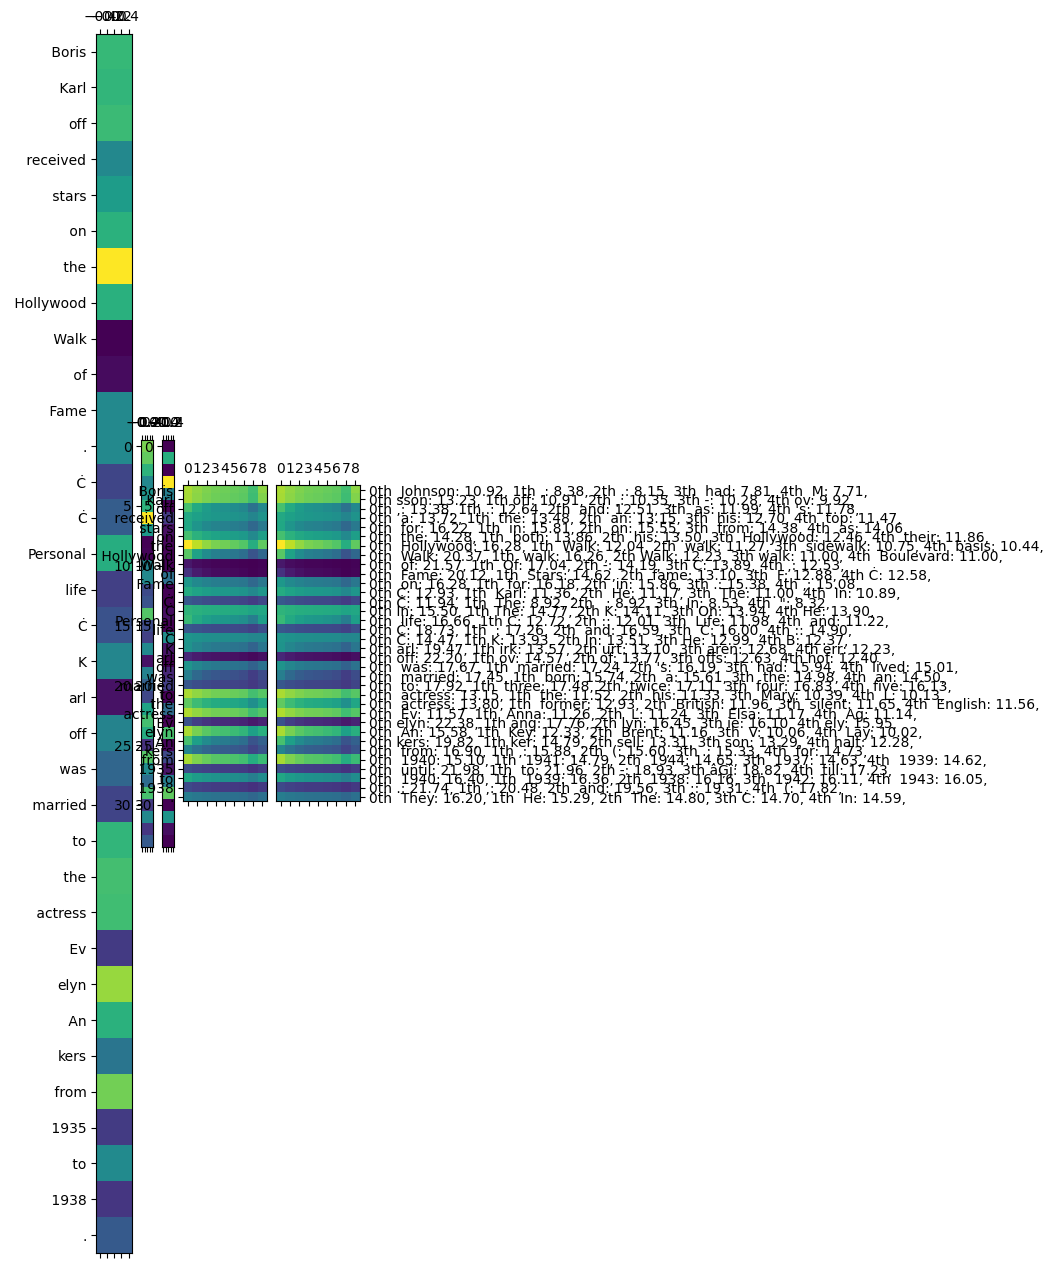

In [17]:
input_ids = torch.tensor(tokenizer.encode(doc)).unsqueeze(0)  # Batch size 1
input_ids = input_ids.to(model.device)

with torch.no_grad():
    #output = model(input_ids,return_dict=False)
    output = model(input_ids,return_dict=False, create_very_large_size=True)
#uncertainty_score1 = (output[1][:,:,-2] - output[2][:,:,0,0]).view(-1,1).cpu()
#uncertainty_score2 = (output[1][:,:,-1] - output[2][:,:,0,0]).view(-1,1).cpu()
uncertainty_score1 = (output[1][:,:,-3] - output[2][:,:,0,0]).view(-1,1).cpu()
uncertainty_score2 = (output[1][:,:,-1] - output[2][:,:,0,0]).view(-1,1).cpu()
#uncertainty_score1 = (output[1][:,:,-1] - output[2][:,:,0,0]).view(-1,1).cpu()
#uncertainty_score2 = entropy_tensor.view(-1,1)
uncertainty_score3 = torch.pow(entropy_tensor * torch.maximum(torch.tensor(0), entropy_tensor_small - entropy_tensor),0.5 ).view(-1,1)
#uncertainty_score = torch.cat( (uncertainty_score1, uncertainty_score2, uncertainty_score3) , dim=1 )
text = tokenizer.decode(input_ids[0])
visualize_results(text, uncertainty_score1.numpy(), uncertainty_score2.numpy() , uncertainty_score3.numpy(), output[1].squeeze().cpu().numpy(), output[1].squeeze().cpu().numpy(), top_str)

 